In [35]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [38]:
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub

m = hub.KerasLayer('https://tfhub.dev/google/aiy/vision/classifier/food_V1/1')

ModuleNotFoundError: No module named 'tensorflow_hub'

In [2]:
import pathlib

dataset_dir = "../keepfit/small-training-img-dataset/"
data_dir = pathlib.Path(dataset_dir).with_suffix('')
data_dir

PosixPath('../keepfit/small-training-img-dataset')

In [3]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

268


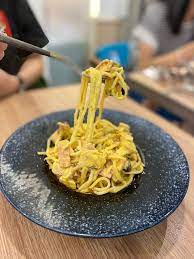

In [4]:
carbonara = list(data_dir.glob('carbonara/*'))
PIL.Image.open(str(carbonara[0]))

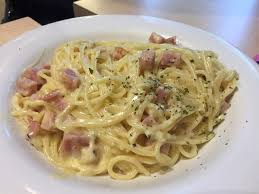

In [5]:
PIL.Image.open(str(carbonara[1]))

In [6]:
batch_size = 32
img_height = 160
img_width = 160
image_szie = (img_height, img_width)

In [7]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 268 files belonging to 4 classes.


Using 215 files for training.


2023-09-15 18:15:02.347302: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-09-15 18:15:02.347327: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-09-15 18:15:02.347336: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-09-15 18:15:02.347768: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-15 18:15:02.348148: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 268 files belonging to 4 classes.


Using 53 files for validation.


In [9]:
validation_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
class_names = train_dataset.class_names
print(class_names)

['alldaybreakfast', 'caesar', 'carbonara', 'risotto']


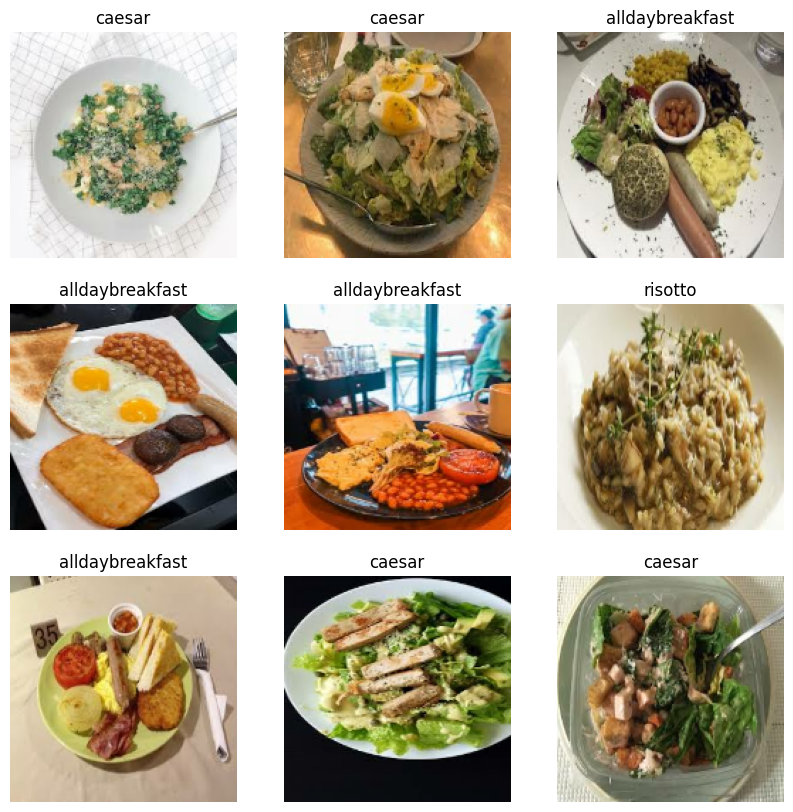

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [15]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2023-09-15 18:15:03.928741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:04.355398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:04.379488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:04.400734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:04.422004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:04.443037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

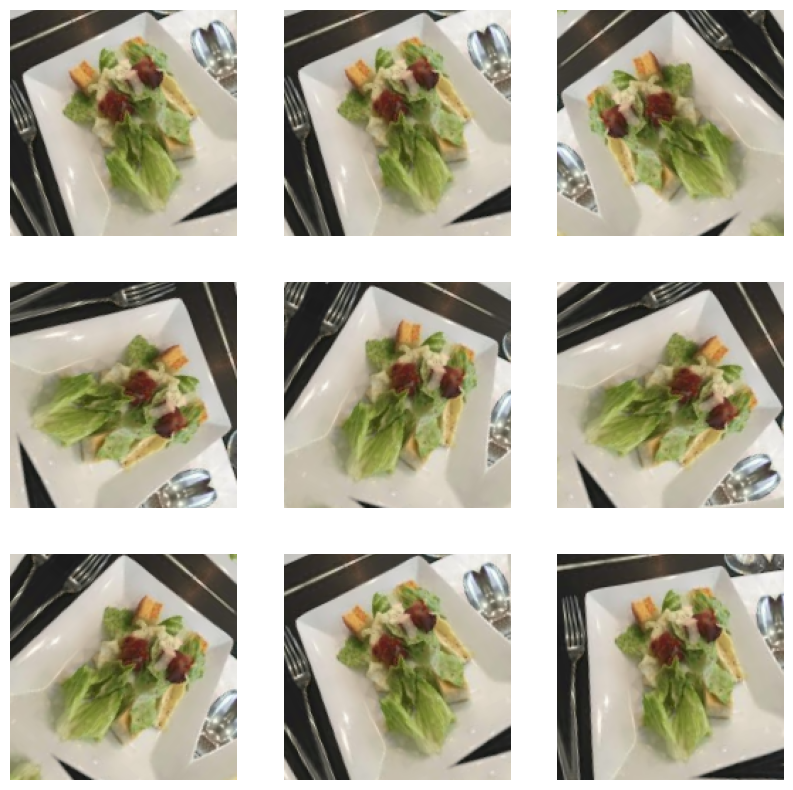

In [16]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [18]:
IMG_SHAPE = image_szie + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [20]:
base_model.trainable = False

In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(3)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [24]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [26]:
len(model.trainable_variables)

2

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-09-15 18:15:07.498695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 320ms/step - loss: 0.9598 - accuracy: 0.3208


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.96
initial accuracy: 0.32


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


2023-09-15 18:15:10.150247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-15 18:15:10.362158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/7 [================>.............] - ETA: 0s - loss: 1.0871 - accuracy: 0.2422

2023-09-15 18:15:11.225228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:11.302888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:11.360651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:11.417965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 1.0386 - accuracy: 0.2257

2023-09-15 18:15:11.478575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:11.535814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 3s 152ms/step - loss: 1.0174 - accuracy: 0.2248 - val_loss: 0.9384 - val_accuracy: 0.3082
Epoch 2/10
2/7 [=======>......................] - ETA: 0s - loss: 1.0463 - accuracy: 0.2708

2023-09-15 18:15:12.140070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.231858: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.288657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.9457 - accuracy: 0.2170

2023-09-15 18:15:12.345924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.404763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.461721: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.519992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 72ms/step - loss: 0.9601 - accuracy: 0.2109 - val_loss: 0.9209 - val_accuracy: 0.3019
Epoch 3/10
2/7 [=======>......................] - ETA: 0s - loss: 0.9143 - accuracy: 0.2240

2023-09-15 18:15:12.663967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.752050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.809962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.9841 - accuracy: 0.2309

2023-09-15 18:15:12.874281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.930990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:12.987859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.044333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 71ms/step - loss: 0.9441 - accuracy: 0.2295 - val_loss: 0.9135 - val_accuracy: 0.2830
Epoch 4/10
3/7 [===========>..................] - ETA: 0s - loss: 0.8993 - accuracy: 0.2535

2023-09-15 18:15:13.181598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.268171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.325603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.8660 - accuracy: 0.2344

2023-09-15 18:15:13.383211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.441737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.500395: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.557327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 86ms/step - loss: 0.8817 - accuracy: 0.2372 - val_loss: 0.8980 - val_accuracy: 0.2516
Epoch 5/10
1/7 [===>..........................] - ETA: 0s - loss: 0.8255 - accuracy: 0.1979

2023-09-15 18:15:13.789060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:13.932232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/7 [================>.............] - ETA: 0s - loss: 0.8381 - accuracy: 0.2396

2023-09-15 18:15:14.007258: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.073059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.143125: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - ETA: 0s - loss: 0.8302 - accuracy: 0.2357

2023-09-15 18:15:14.218084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.288288: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 112ms/step - loss: 0.8302 - accuracy: 0.2357 - val_loss: 0.8831 - val_accuracy: 0.2516
Epoch 6/10
1/7 [===>..........................] - ETA: 0s - loss: 0.7829 - accuracy: 0.2188

2023-09-15 18:15:14.607854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.710106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


4/7 [================>.............] - ETA: 0s - loss: 0.8518 - accuracy: 0.2474

2023-09-15 18:15:14.814563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.894770: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:14.956865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - ETA: 0s - loss: 0.7834 - accuracy: 0.2279

2023-09-15 18:15:15.020535: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:15.079939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 110ms/step - loss: 0.7834 - accuracy: 0.2279 - val_loss: 0.8595 - val_accuracy: 0.2579
Epoch 7/10
1/7 [===>..........................] - ETA: 0s - loss: 0.7103 - accuracy: 0.2396

2023-09-15 18:15:15.373377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:15.514634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


5/7 [====================>.........] - ETA: 0s - loss: 0.8258 - accuracy: 0.2604

2023-09-15 18:15:15.581873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:15.644629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:15.703888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:15.766226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 87ms/step - loss: 0.7939 - accuracy: 0.2527 - val_loss: 0.8393 - val_accuracy: 0.2704


2023-09-15 18:15:15.825412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


Epoch 8/10
2/7 [=======>......................] - ETA: 0s - loss: 0.6625 - accuracy: 0.2604

2023-09-15 18:15:16.030928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.133705: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.202387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.7834 - accuracy: 0.2413

2023-09-15 18:15:16.283407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.342856: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.402790: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.468013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 86ms/step - loss: 0.7807 - accuracy: 0.2403 - val_loss: 0.8209 - val_accuracy: 0.2390
Epoch 9/10
3/7 [===========>..................] - ETA: 0s - loss: 0.6075 - accuracy: 0.2431

2023-09-15 18:15:16.649354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.737387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.792920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.7627 - accuracy: 0.2569

2023-09-15 18:15:16.850424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.906982: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:16.963984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.023136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 71ms/step - loss: 0.7680 - accuracy: 0.2651 - val_loss: 0.8036 - val_accuracy: 0.2264
Epoch 10/10
3/7 [===========>..................] - ETA: 0s - loss: 0.6770 - accuracy: 0.2500

2023-09-15 18:15:17.161159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.242551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.298603: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.356159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


6/7 [========================>.....] - ETA: 0s - loss: 0.7193 - accuracy: 0.2326

2023-09-15 18:15:17.419783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.492536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-09-15 18:15:17.547954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


7/7 [==============================] - 1s 73ms/step - loss: 0.7482 - accuracy: 0.2326 - val_loss: 0.7882 - val_accuracy: 0.2201


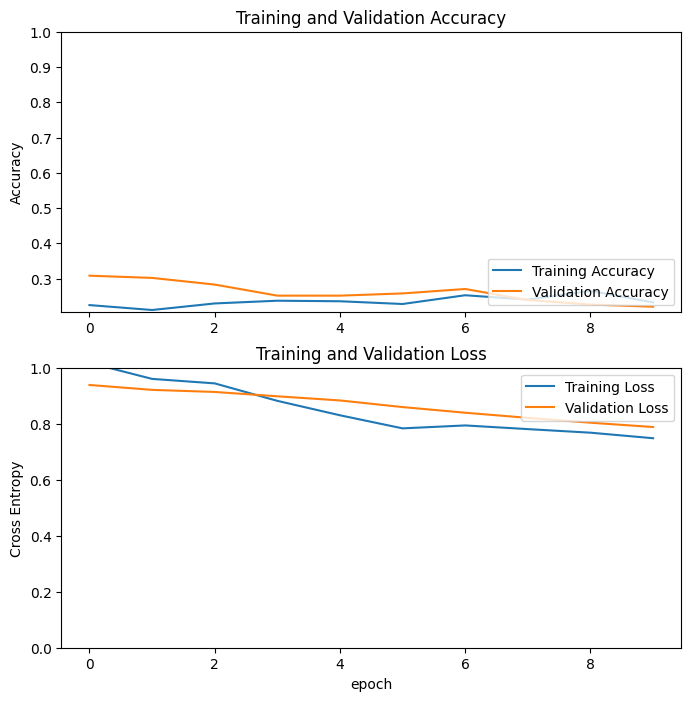

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()